In [1]:
import zipfile
import os

def unzip_file(zip_file_path, extract_to_path):
    # Check if the specified zip file exists
    if not os.path.exists(zip_file_path):
        print(f"The file {zip_file_path} does not exist")
        return

    # Create the directory if it does not exist
    if not os.path.exists(extract_to_path):
        os.makedirs(extract_to_path)

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print(f"Extracted all files to {extract_to_path}")

# Example usage
zip_file_path = '/content/skin2_split.zip'
extract_to_path = '/content'
unzip_file(zip_file_path, extract_to_path)


Extracted all files to /content


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import tensorflow as tf
# from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
# from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
# # from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
# from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
!ls

model_v3.ipynb	sample_data  skin2_split  skin2_split.zip


In [4]:
class AccuracyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.94 and val_accuracy > 0.89:
                print("\nTraining stopped as accuracy reached above 94% & validation accuracy reached above 89%")
                self.model.stop_training = True

In [5]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=40,
        zoom_range=0.2,
        shear_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.2, 1.0],
        fill_mode='nearest',
        rescale=1.0 / 255,
    )

    for i in range(num_augmentations):
        augmented_images.extend(data_augmentation.flow(images, batch_size=len(images), shuffle=False).next())
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.uint8)

    return augmented_images, augmented_labels

In [6]:
# Check the number of images in each category
train_dir = 'skin2_split/train/'
num_normal_train = len(os.listdir(os.path.join(train_dir, 'normal')))
num_dry_train = len(os.listdir(os.path.join(train_dir, 'kering')))
num_oily_train = len(os.listdir(os.path.join(train_dir, 'berminyak')))
print("===TRAIN===")
print("Number of normal images:", num_normal_train)
print("Number of dry images:", num_dry_train)
print("Number of oily images:", num_oily_train)

val_dir = 'skin2_split/val/'
num_normal_val = len(os.listdir(os.path.join(val_dir, 'normal')))
num_dry_val = len(os.listdir(os.path.join(val_dir, 'kering')))
num_oily_val = len(os.listdir(os.path.join(val_dir, 'berminyak')))
print("\n===VAL===")
print("Number of normal images:", num_normal_val)
print("Number of dry images:", num_dry_val)
print("Number of oily images:", num_oily_val)

===TRAIN===
Number of normal images: 290
Number of dry images: 322
Number of oily images: 319

===VAL===
Number of normal images: 74
Number of dry images: 83
Number of oily images: 79


In [7]:
# Create dataframes for train and validation data
data_train = []
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_train.append((img_path, category))

train_df = pd.DataFrame(data_train, columns=['Path', 'Label'])

data_val = []
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_val.append((img_path, category))

val_df = pd.DataFrame(data_val, columns=['Path', 'Label'])


In [8]:
# Load training images into numpy arrays
def load_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['Path']
        label = row['Label']
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    images = np.array(images, dtype=np.float32)
    labels = pd.get_dummies(labels).values
    return images, labels

train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)

In [9]:
# Apply image augmentation
augmented_train_images, augmented_train_labels = image_augmentation(
    train_images, train_labels, num_augmentations=5)

In [10]:
# Use ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=32
)

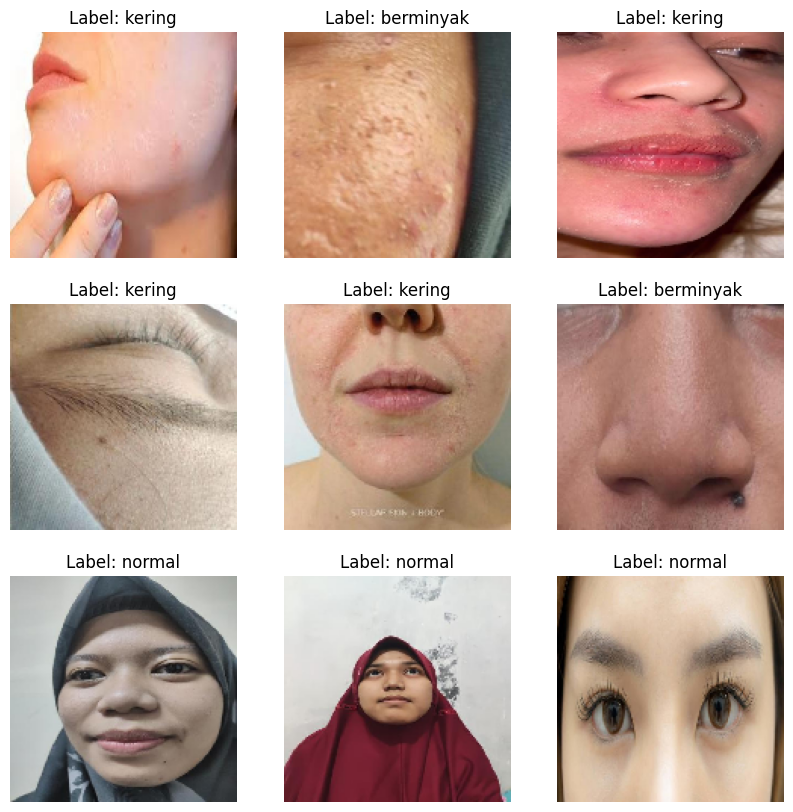

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_idx = random.randint(0, len(train_df) - 1)
    random_img_path = train_df.iloc[random_idx]['Path']
    random_img_label = train_df.iloc[random_idx]['Label']
    random_img = load_img(random_img_path, target_size=(150, 150))
    plt.imshow(random_img)
    plt.title(f"Label: {random_img_label}")
    plt.axis('off')
plt.show()

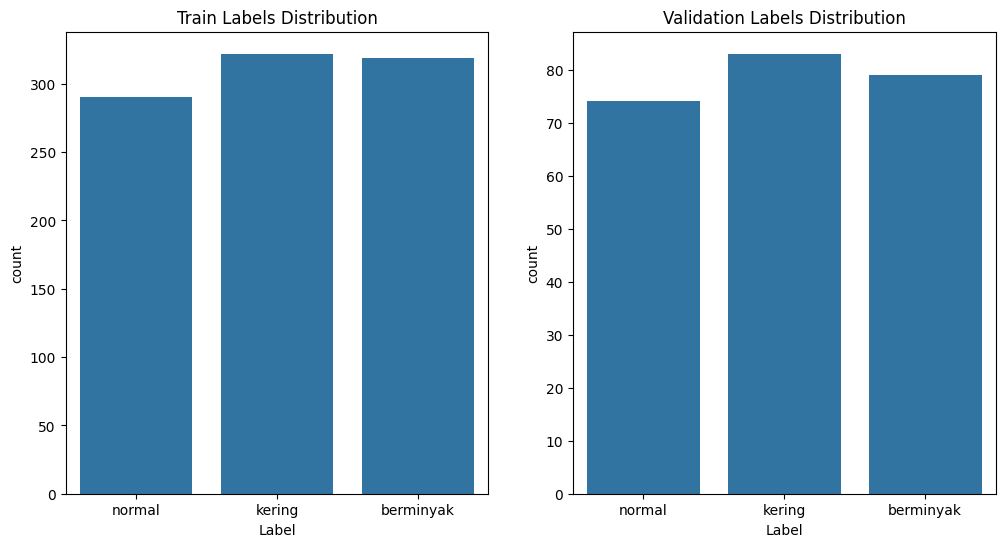

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='Label')
plt.title('Train Labels Distribution')
plt.subplot(1, 2, 2)
sns.countplot(data=val_df, x='Label')
plt.title('Validation Labels Distribution')
plt.show()

In [13]:
# Load pre-trained MobileNetV2 model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
last_layer = base_model.output
x = layers.GlobalAveragePooling2D()(last_layer)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Get the number of classes from the train generator's class indices
num_classes = train_labels.shape[1]
x = layers.Dense(num_classes, activation='softmax')(x)

# Define the model
model = models.Model(inputs=base_model.input, outputs=x)

17225924/17225924 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model with the callback
callback = AccuracyStoppingCallback()

In [17]:
# Train the model
history = model.fit(
    augmented_train_images, augmented_train_labels,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[callback]
)

Epoch 1/20
146/146 [==============================] - 1029s 7s/step - loss: 1.0461 - accuracy: 0.6122 - val_loss: 4.4060 - val_accuracy: 0.4915
Epoch 2/20
146/146 [==============================] - 1001s 7s/step - loss: 0.4252 - accuracy: 0.8387 - val_loss: 0.9456 - val_accuracy: 0.7839
Epoch 3/20
146/146 [==============================] - 979s 7s/step - loss: 0.2989 - accuracy: 0.9008 - val_loss: 0.3450 - val_accuracy: 0.8686
Epoch 4/20
146/146 [==============================] - 985s 7s/step - loss: 0.2214 - accuracy: 0.9224 - val_loss: 0.4101 - val_accuracy: 0.8644
Epoch 5/20
146/146 [==============================] - 861s 6s/step - loss: 0.1718 - accuracy: 0.9435 - val_loss: 0.5621 - val_accuracy: 0.8602
Epoch 6/20
146/146 [==============================] - 813s 6s/step - loss: 0.1460 - accuracy: 0.9523 - val_loss: 0.7247 - val_accuracy: 0.8305
Epoch 7/20
146/146 [==============================] - 810s 6s/step - loss: 0.1345 - accuracy: 0.9553 - val_loss: 0.8485 - val_accuracy: 0.79

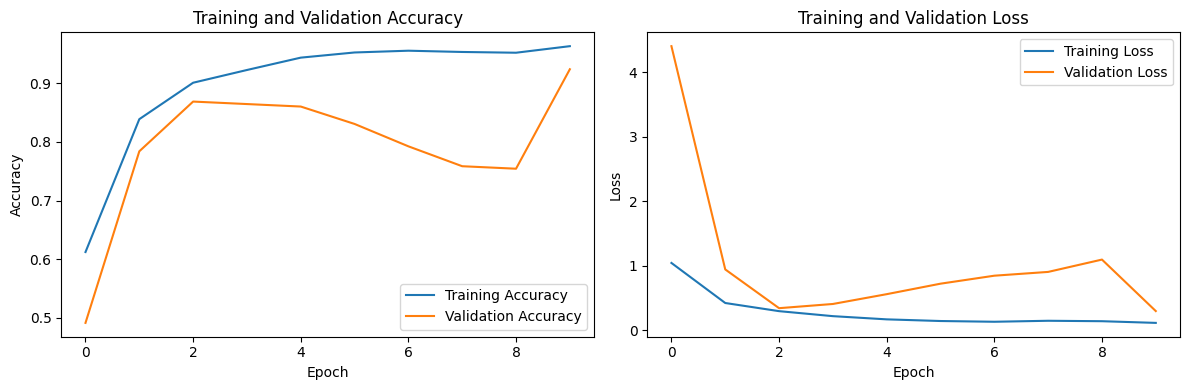

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [19]:
# Confusion matrix function
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=45)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

8/8 [==============================] - 13s 1s/step


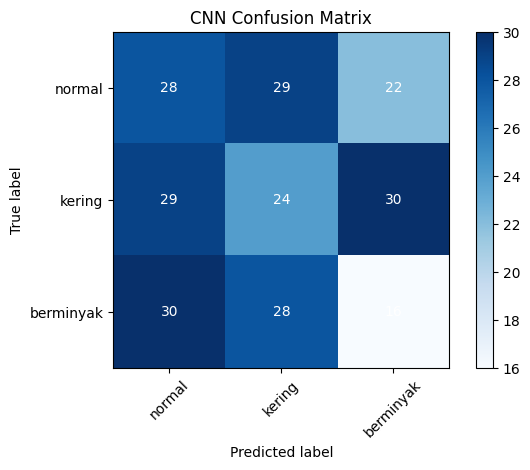

In [20]:
# Validate the model
val_generator.reset()
y_val_pred = model.predict(val_generator)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
val_labels_true = np.argmax(val_labels, axis=1)
class_names = list(train_df['Label'].unique())
plot_confusion_matrix(val_labels_true, y_val_pred_labels, classes=class_names, title='CNN Confusion Matrix')
plt.show()

In [21]:
# Evaluate the model on the validation set
val_generator.reset()
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc}')

8/8 [==============================] - 9s 1s/step - loss: 0.3003 - accuracy: 0.9237
Validation Accuracy: 0.9237288236618042


8/8 [==============================] - 14s 2s/step


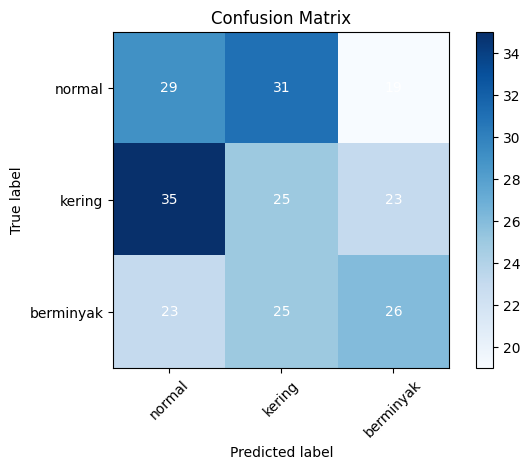

In [22]:
# Generate predictions
val_generator.reset()
y_val_pred = model.predict(val_generator)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
val_labels_true = np.argmax(val_labels, axis=1)

# Plot confusion matrix
plot_confusion_matrix(val_labels_true, y_val_pred_labels, classes=class_names, title='Confusion Matrix')
plt.show()

In [23]:
# Classification report
print("Classification Report:")
print(classification_report(val_labels_true, y_val_pred_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      normal       0.33      0.37      0.35        79
      kering       0.31      0.30      0.30        83
   berminyak       0.38      0.35      0.37        74

    accuracy                           0.34       236
   macro avg       0.34      0.34      0.34       236
weighted avg       0.34      0.34      0.34       236



In [24]:
# Test generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'skin2_split/test/',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 123 images belonging to 3 classes.


In [25]:
# Evaluate the model on the test set
test_generator.reset()
test_pred = model.predict(test_generator)
y_test_pred_labels = np.argmax(test_pred, axis=1)
test_labels = test_generator.classes
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

8/8 [==============================] - 5s 484ms/step - loss: 0.6296 - accuracy: 0.8699
Test accuracy: 0.869918704032898


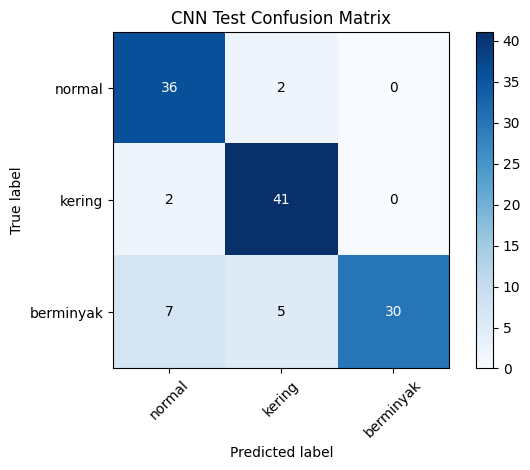

In [26]:
# Plot confusion matrix for test set
plot_confusion_matrix(test_labels, y_test_pred_labels, classes=class_names, title='CNN Test Confusion Matrix')
plt.show()

In [27]:
# Classification report for test data
print("Classification Report for CNN Model on Test Data:")
print(classification_report(test_labels, y_test_pred_labels, target_names=class_names))

Classification Report for CNN Model on Test Data:
              precision    recall  f1-score   support

      normal       0.80      0.95      0.87        38
      kering       0.85      0.95      0.90        43
   berminyak       1.00      0.71      0.83        42

    accuracy                           0.87       123
   macro avg       0.88      0.87      0.87       123
weighted avg       0.89      0.87      0.87       123



1/1 [==============================] - 0s 55ms/step


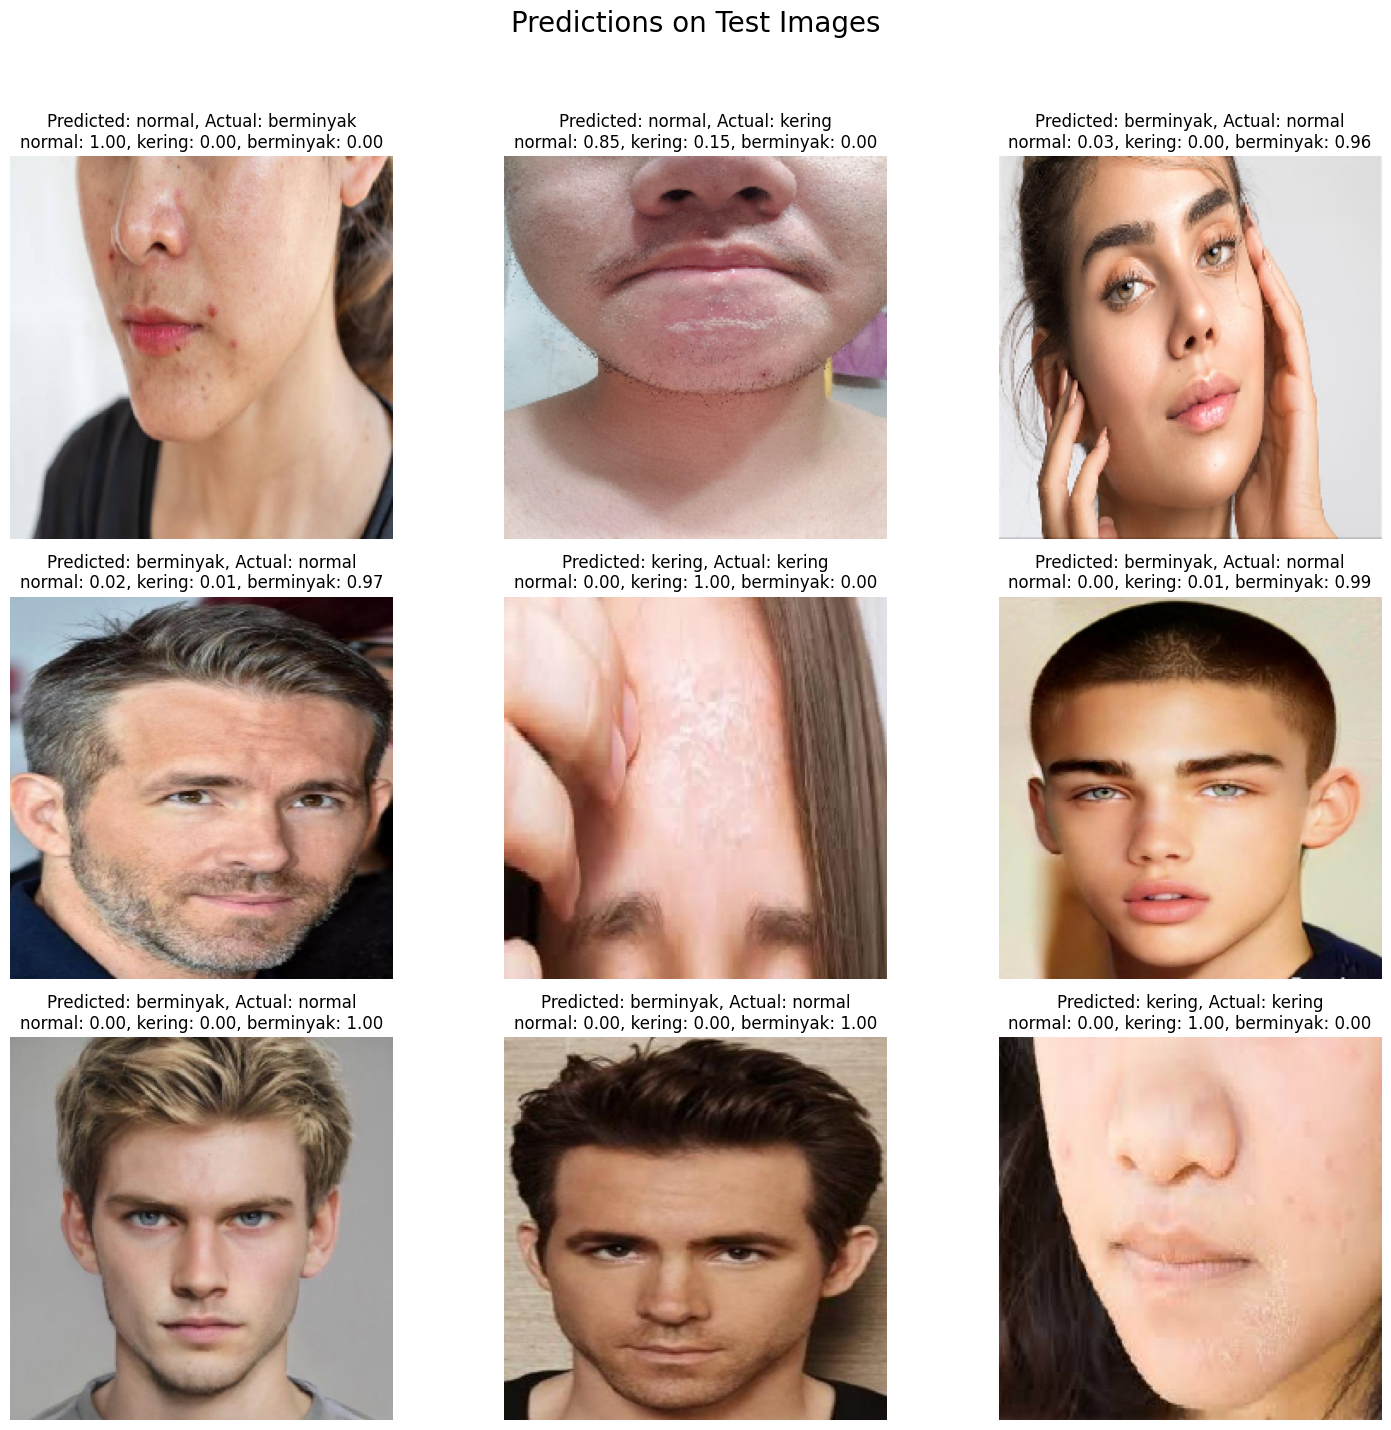

In [30]:
plt.figure(figsize=(15, 15))
plt.suptitle('Predictions on Test Images', fontsize=20)

num_samples = 9
for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    img_index = random.randint(0, len(test_generator.filenames) - 1)
    img_path = test_generator.filenames[img_index]

    # Construct the full path to the image
    full_img_path = os.path.join(test_generator.directory, img_path)

    img = load_img(full_img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image data
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Extract the true class label from the directory structure
    true_class = os.path.basename(os.path.dirname(full_img_path))

    labels_str = ', '.join([f'{class_names[j]}: {prediction[0][j]:.2f}' for j in range(len(class_names))])
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}\n{labels_str}', fontsize=12)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [31]:
saved_model_path = "./my_model.h5"

model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

/bin/bash: line 1: tensorflowjs_converter: command not found


# New Section

In [1]:
!pip install tensorflowjs

In [3]:
!tensorflowjs_converter --version

2024-06-09 07:54:00.464582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 07:54:02.835773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

tensorflowjs 4.20.0

Dependency versions:
  keras 2.16.0
  tensorflow 2.16.1


In [2]:
!tensorflowjs_converter --input_format=keras /content/my_model.h5 /content/

2024-06-09 07:53:28.864992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 07:53:30.875627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
!zip submission.zip *.bin model.json

  adding: group1-shard1of4.bin (deflated 7%)
  adding: group1-shard2of4.bin (deflated 7%)
  adding: group1-shard3of4.bin (deflated 7%)
  adding: group1-shard4of4.bin (deflated 8%)
  adding: model.json (deflated 95%)


In [5]:
ls

group1-shard1of4.bin  group1-shard4of4.bin  my_model.h5   skin2_split.zip
group1-shard2of4.bin  model.json            sample_data/  submission.zip
group1-shard3of4.bin  model_v3.ipynb        skin2_split/
